<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.9.0
numpy 1.26.4
pandas 2.2.2
sklearn 1.5.0
torch 2.3.1+cpu
cpu


## 数据准备

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 这里用 random_split 按照 11 : 1 的比例来划分数据集
train_ds, val_ds = random_split(train_ds, [55000, 5000], torch.Generator().manual_seed(seed))

In [3]:
from torchvision.transforms import Normalize

# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


# print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2856], [0.3202])
)

In [4]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

## 定义模型

使用深度可分离的卷积

pytorch需要自行实现

In [5]:
# 定义深度可分离卷积层，torch没有实现，tf有实现
class DepthWiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(DepthWiseConv2d, self).__init__() #这里写为super().__init__()，等价的
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False) #groups参数表示一个卷积核的每个通道分别进行运算
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=bias)
    
    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

In [6]:

class CNN(nn.Module):
    def __init__(self, activation="relu"):
        super(CNN, self).__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = DepthWiseConv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = DepthWiseConv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = DepthWiseConv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.conv5 = DepthWiseConv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = DepthWiseConv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        act = self.activation
        #x -->(batch_size, 1, 28, 28)
        x = self.pool(act(self.conv2(act(self.conv1(x)))))  # (batch_size, 32, 14, 14)
        x = self.pool(act(self.conv4(act(self.conv3(x)))))  # (batch_size, 64, 7, 7)
        x = self.pool(act(self.conv6(act(self.conv5(x)))))  # (batch_size, 128, 3, 3)
        x = self.flatten(x) # (batch_size, 128 * 3 * 3)
        x = act(self.fc1(x)) # (batch_size, 128)
        x = self.fc2(x) # (batch_size, 10)
        return x
    

for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")


conv1.weight	paramerters num: 288
conv1.bias	paramerters num: 32
conv2.depthwise_conv.weight	paramerters num: 288
conv2.pointwise_conv.weight	paramerters num: 1024
conv2.pointwise_conv.bias	paramerters num: 32
conv3.depthwise_conv.weight	paramerters num: 288
conv3.pointwise_conv.weight	paramerters num: 2048
conv3.pointwise_conv.bias	paramerters num: 64
conv4.depthwise_conv.weight	paramerters num: 576
conv4.pointwise_conv.weight	paramerters num: 4096
conv4.pointwise_conv.bias	paramerters num: 64
conv5.depthwise_conv.weight	paramerters num: 576
conv5.pointwise_conv.weight	paramerters num: 8192
conv5.pointwise_conv.bias	paramerters num: 128
conv6.depthwise_conv.weight	paramerters num: 1152
conv6.pointwise_conv.weight	paramerters num: 16384
conv6.pointwise_conv.bias	paramerters num: 128
fc1.weight	paramerters num: 147456
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [ ]:
# 总权重数 = 288 + 288 + 1024 + 2048 + 576 + 8192 + 1152 + 16384 + 147456 + 1280 = 186624
# 总偏置数 = 32 + 32 + 64 + 64 + 128 + 128 + 10 = 438
#
# 整个网络的总参数数为：
#
# 总参数数 = 总权重数 + 总偏置数 = 186624 + 438 = 187062

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [7]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [8]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [9]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [10]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [11]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                    
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

activation = "selu"
model = CNN(activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/dsc-{activation}")
tensorboard_callback.draw_model(model, [1, 1, 28, 28])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/dsc-{activation}", save_step=len(train_loader), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

2023-04-10 20:45:50.148376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/34380 [00:00<?, ?it/s]

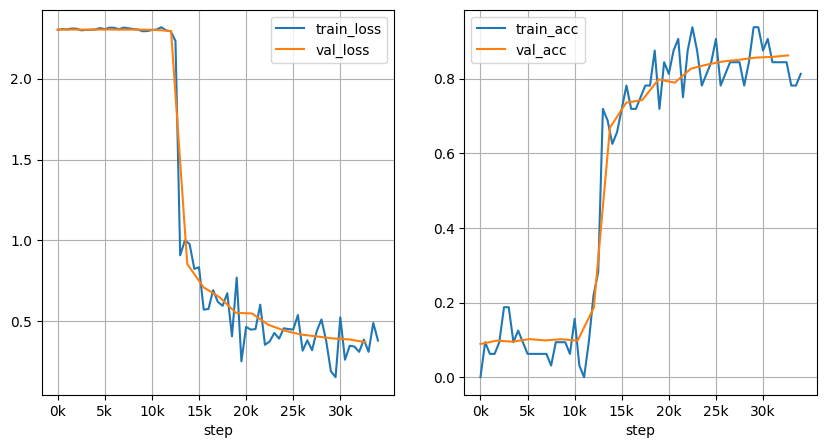

In [12]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

# 评估

In [13]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/dsc-{activation}/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3736
accuracy: 0.8625
